# How to Build Your Own AI-Generated Image Augmentation Tools

In [ ]:
#!/usr/bin/env python
# -*-coding:utf-8 -*-
"""
  ████
██    ██   Datature
  ██  ██   Powering Breakthrough AI
    ██

@File    :   product_generation_demo.ipynb
@Author  :   Wei Loon Cheng
@Version :   1.0
@Contact :   hello@datature.io
@License :   Apache License 2.0
@Desc    :   Jupyter notebook to build augmented product images with generative AI.
"""

## Introduction

This notebooks serves as an example on how to use generative AI methods together with traditional Computer Vision algorithms for image augmentation. The task for this example will be background augmentation for single objects, which can be used for a variety of applications such as object identification and product placement.

## Prerequisites

The generative AI models used in this notebook are computationally intensive. Please ensure that you are running on a GPU with at least 12GB of VRAM.

In [1]:
%pip install -U albumentations
%pip install -U datature
%pip install -U diffusers
%pip install -U h5py
%pip install -U imantics
%pip install -U matplotlib
%pip install -U numpy
%pip install -U opencv-python
%pip install -U Pillow
%pip install -U typing-extensions
%pip install -U wget
%pip install -U wheel

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated pa

In [2]:
import json
import random
import time
import urllib
from zipfile import ZipFile

import albumentations as A
import cv2
import datature
import matplotlib.pyplot as plt
import numpy as np
import torch
import wget
from diffusers import StableDiffusionInpaintPipeline
from imantics import Mask, Polygons
from PIL import Image

## Input Parameters and Constants

Feel free to vary the parameters as you wish if the generated images are not to your liking.

In [3]:
DEVICE = torch.device(0)

# Set your Nexus project secret key here for SDK authentication
datature.secret_key = "<YOUR_SECRET_KEY>"

# Set a seed for reproducibility
SEED = 2023
random.seed(SEED)

# File names for augmented image and annotations
AUGMENTED_IMAGE_FILENAME = "tumeric_new.png"
AUGMENTED_IMAGE_ANNOTATION_FILENAME = "annotation.json"

# Change this to vary the input size to the model
HEIGHT, WIDTH = 512, 512

# Change this to generate multiple images each run at the cost of increased GPU memory usage.
NUM_IMAGES_PER_PROMPT = 1

# Change this to vary the level of detail in the output image.
# Higher values means higher quality and more detail at the cost of longer inference time.
NUM_INFERENCE_STEPS = 50

# Change this to vary how much the generation should follow the input prompt.
# Too high or too low values may result in poor quality images.
# A reasonable value is between 7.0 and 9.0.
GUIDANCE_SCALE = 7.5

# Margin around the object mask to remove before inpainting.
MARGIN_BORDER = 20

# Generic list of keywords to guide generation away from
NEGATIVE_PROMPT = (
    f"bad anatomy, bad proportions, blurry, cloned face, cropped,"
    f" deformed, dehydrated, disfigured, duplicate, error, extra arms,"
    f" extra fingers, extra legs, extra limbs, fused fingers,"
    f" gross proportions, jpeg artifacts, long neck, low quality, lowres,"
    f" malformed limbs, missing arms, missing legs, morbid, mutated hands,"
    f" mutation, mutilated, out of frame, poorly drawn face,"
    f" poorly drawn hands, signature, text, too many fingers, ugly,"
    f" username, watermark, worst quality, words, symbols")

# Input prompt
PROMPT = "on a table with tumeric and ginger"

## Object Transformation

This is a simple example that shifts, scales, and rotates the object by a random factor within the specified bounds. Feel free to vary the bounds or to change the transformations altogether. To learn more about the available transformations and advanced customization, check out the [Albumentations docs](https://albumentations.ai/docs/getting_started/transforms_and_targets/).

In [4]:
TRANSFORM = A.ReplayCompose([
    A.ShiftScaleRotate(shift_limit=0.3,
                       scale_limit=[-0.6, -0.5],
                       rotate_limit=10,
                       p=1.0,
                       border_mode=cv2.BORDER_CONSTANT,
                       value=[255, 255, 255],
                       mask_value=[255, 255, 255])
])

## Object Polygon Segmentation

The polygon segmentation example is exported from Datature [Nexus](https://www.datature.io/nexus) using Datature SDK. Do check out the platform if you wish to obtain segmentation annotations. Alternatively, you can skip this step if you already have a binary mask of the object available.

In [5]:
# Download image from Nexus
print("Downloading image from Nexus...")
asset = datature.Asset.list()["data"][-1]
asset_url = asset["url"]
asset_filename = asset["filename"]
urllib.request.urlretrieve(asset_url, asset_filename)

# Download polygon annotation from Nexus
print("Downloading annotations from Nexus...")
operation = datature.Annotation.export("polygon_single", {
    "normalized": False,
    "shuffle": False,
    "split_ratio": 0.0,
    "seed": 1,
},
                                       background=True)
while datature.Operation.retrieve(
        operation["op_link"]
)["status"]["progress"]["with_status"]["finished"] != 1:
    time.sleep(1)

annotation_url = datature.Annotation.retrieve_exported_file(
    operation["id"])["download"]["url"]

annotation_zipfile = wget.download(annotation_url)
with ZipFile(annotation_zipfile, 'r') as zObject:
    annotation_filename = zObject.namelist()[-1]
    zObject.extractall()

print("Downloads complete!")

100% [............................................................................] 621929 / 621929Downloading annotations from Nexus...
100% [................................................................................] 1097 / 1097Downloads complete!


In [6]:
def annotation_to_mask(image, annotation):
    """Converts annotation to binary mask and saves it to disk.

    Args:
        image (np.array): Image to be masked.
        annotation (list):
            Annotation coordinates in the form of [x1, y1, x2, y2, ...].
    """
    mask = np.ones(image.shape[:2], np.float32) * 255
    cv2.fillPoly(mask, [np.array(annotation).astype(int)], color=(0, 0, 0))
    cv2.imwrite("mask.png", mask)

## Image Generation Pipeline

The model typically used is Stable Diffusion v2.1. If you want to use a different model, check out [HuggingFace](https://huggingface.co/) for a list of open-source community models.

In [7]:
# Load SD2 in-painting model
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting").to(DEVICE)

# Set generator seed for reproducibility
generator = torch.Generator(device=DEVICE)
generator = generator.manual_seed(SEED)

/home/datature/.virtualenvs/inpainting/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/home/datature/.virtualenvs/inpainting/lib/python3.10/site-packages/transformers/modeling_utils.py:402: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(checkpoint_file, framework="pt") as f:
/home/datature/.virtualenvs/inpainting/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using sto

### Load image and convert polygon annotation to binary mask

You can skip the polygon annotation to binary mask step if you already have a binary mask of the object.

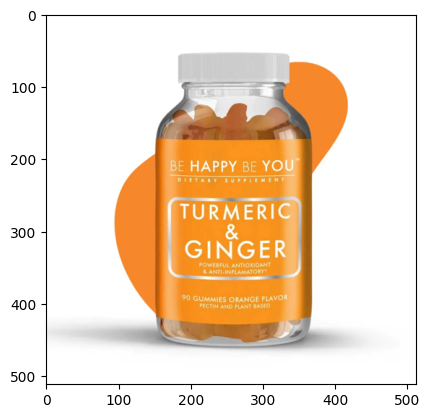

In [8]:
image = cv2.imread(asset_filename)
annotation_object = json.load(open(annotation_filename))
annotation = annotation_object["shapes"][-1]["points"]
mask_image = annotation_to_mask(image, annotation)

input_image = Image.open(asset_filename).resize((HEIGHT, WIDTH))
input_shape = input_image.size
resize_factor = HEIGHT / max(input_shape)
resize_shape = (int(resize_factor * input_shape[0]),
                int(resize_factor * input_shape[1]))

plt.imshow(input_image)

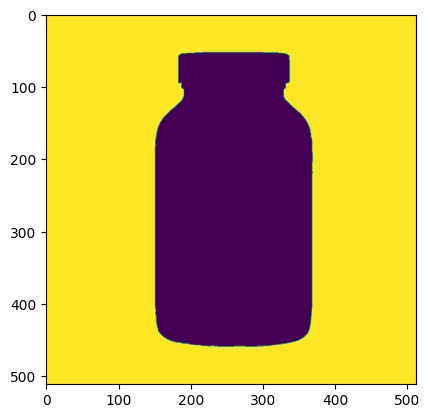

In [9]:
mask_image = Image.open("mask.png").resize((HEIGHT, WIDTH))
plt.imshow(mask_image)

### Randomly apply transformations to the image and mask

In [10]:
transformed = TRANSFORM(image=np.array(input_image), mask=np.array(mask_image))

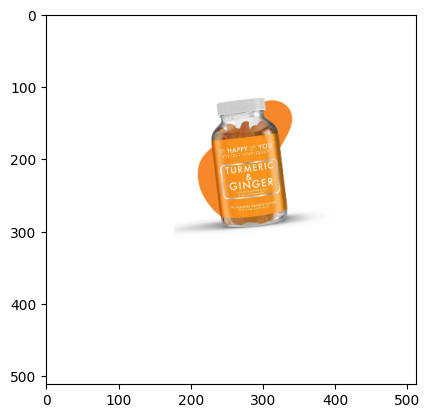

In [11]:
plt.imshow(transformed["image"])

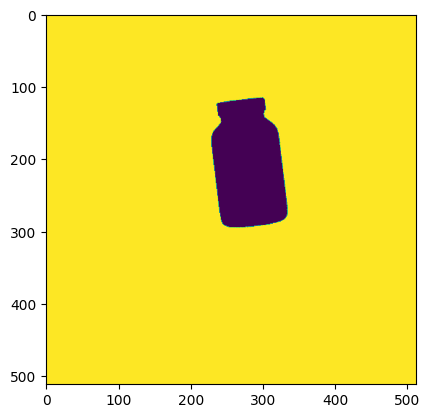

In [12]:
plt.imshow(transformed["mask"])

### Further preprocessing of the model input

The mask borders are slightly adjusted before a minimum bounding box is created. This minimises the chance that Stable Diffusion erroneously generates an object with a similar shape to the original object based on the shape of the binary mask instead of a generic background.

In [13]:
# Invert mask
mask_invert = cv2.bitwise_not(transformed["mask"])

# Dilate mask
kernel = np.ones((5, 5), np.uint8)
mask_dilate = cv2.dilate(transformed["mask"], kernel, iterations=2)

# Erode and invert mask
mask_erode = cv2.erode(transformed["mask"], kernel, iterations=25)
mask_invert_erode = cv2.bitwise_not(mask_erode)

# Create minimum bounding box around the mask
contours, hierarchy = cv2.findContours(mask_invert_erode, cv2.RETR_TREE,
                                       cv2.CHAIN_APPROX_SIMPLE)
mask_invert_erode = np.zeros(
    (mask_invert_erode.shape[0], mask_invert_erode.shape[1]), dtype=np.uint8)
xmin, ymin, width, height = cv2.boundingRect(contours[0])
cv2.rectangle(mask_invert_erode, (xmin - MARGIN_BORDER, ymin - MARGIN_BORDER),
              (xmin + width + MARGIN_BORDER, ymin + height + MARGIN_BORDER),
              color=(255, 255, 255),
              thickness=-1)

mask_dilate = Image.fromarray(mask_dilate)

### Run inference to in-paint the background

  0%|          | 0/50 [00:00<?, ?it/s]

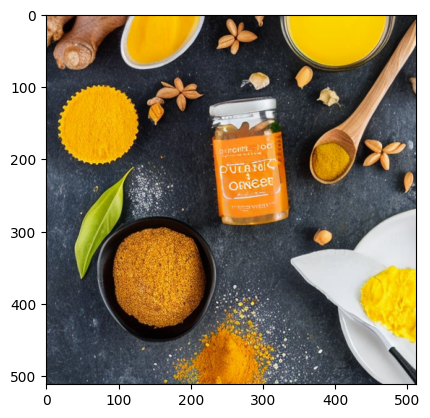

In [14]:
out_images = pipe(prompt=PROMPT,
                  negative_prompt=NEGATIVE_PROMPT,
                  image=Image.fromarray(transformed["image"]),
                  mask_image=mask_dilate,
                  height=HEIGHT,
                  width=WIDTH,
                  num_images_per_prompt=NUM_IMAGES_PER_PROMPT,
                  num_inference_steps=NUM_INFERENCE_STEPS,
                  guidance_scale=GUIDANCE_SCALE,
                  generator=generator).images
plt.imshow(out_images[-1])

### Further preprocessing for the second stage of in-painting

The object is masked out from the generated image in the first stage so that a natural image of the background can be generated in the second stage.

In [15]:
out_image = np.array(out_images[-1])
image_object_invert = cv2.bitwise_and(out_image,
                                      out_image,
                                      mask=cv2.bitwise_not(mask_invert_erode))
image_object_invert = Image.fromarray(image_object_invert)
mask_invert_erode = Image.fromarray(mask_invert_erode)

### Run inference to in-paint the full background

  0%|          | 0/50 [00:00<?, ?it/s]

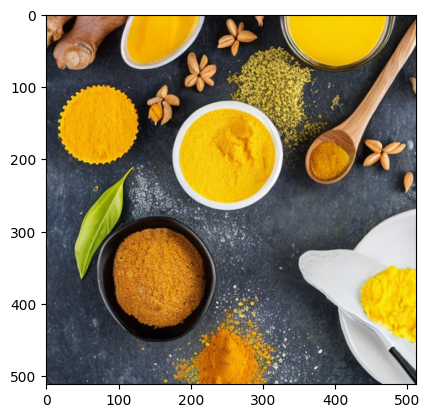

In [16]:
# Run inpainting to fill in background
out_backgrounds = pipe(prompt=PROMPT,
                       negative_prompt=NEGATIVE_PROMPT,
                       image=image_object_invert,
                       mask_image=mask_invert_erode,
                       height=HEIGHT,
                       width=WIDTH,
                       num_images_per_prompt=NUM_IMAGES_PER_PROMPT,
                       num_inference_steps=NUM_INFERENCE_STEPS,
                       guidance_scale=GUIDANCE_SCALE,
                       generator=generator).images
plt.imshow(out_backgrounds[-1])

### Image overlay

The original object is masked out from the original image and overlaid onto the newly-generated background.

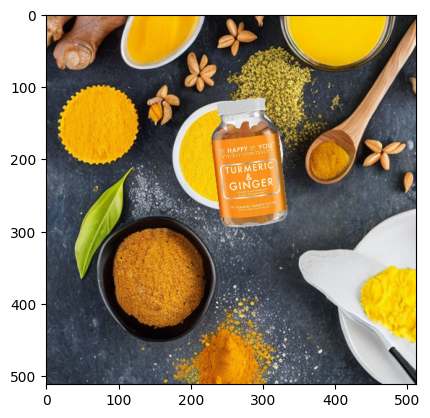

In [17]:
final_out_image = cv2.cvtColor(transformed["image"], cv2.COLOR_BGRA2BGR)
original_image = cv2.cvtColor(transformed["image"], cv2.COLOR_BGRA2BGR)
background = np.array(out_backgrounds[-1])

# Overlay object on background
for i in range(final_out_image.shape[0]):
    for j in range(final_out_image.shape[1]):
        if transformed["mask"][i][j] <= 100:
            final_out_image[i][j][:] = original_image[i][j][:]
        else:
            final_out_image[i][j][:] = background[i][j][:]

# Resize and save the final image
final_out_image = cv2.resize(final_out_image, resize_shape)
plt.imshow(final_out_image)

### Save output image and transformed mask as polygon annotation

In [18]:
final_out_image = cv2.cvtColor(final_out_image, cv2.COLOR_BGR2RGB)
cv2.imwrite(AUGMENTED_IMAGE_FILENAME, final_out_image)

polygons = Mask(transformed["mask"]).polygons()
annotation_object["shapes"][-1]["points"] = polygons.points[0].tolist()
annotation_object["imagePath"] = AUGMENTED_IMAGE_FILENAME

json_object = json.dumps(annotation_object, indent=4)
with open(AUGMENTED_IMAGE_ANNOTATION_FILENAME, "w") as outfile:
    outfile.write(json_object)

### Upload output image and polygon annotation back to Nexus

In [19]:
# Upload output image to Nexus
print("Uploading output image...")
upload_session = datature.Asset.upload_session()
upload_session.add(AUGMENTED_IMAGE_FILENAME)
operation = upload_session.start(["augmentations"], background=True)
while datature.Operation.retrieve(
        operation["op_link"]
)["status"]["progress"]["with_status"]["finished"] != 1:
    time.sleep(1)

# Upload annotation of augmented image to Nexus
print("Uploading annotation of augmented image...")
operation = datature.Annotation.upload("polygon_single",
                                       AUGMENTED_IMAGE_ANNOTATION_FILENAME,
                                       background=True)
while datature.Operation.retrieve(
        operation["op_link"]
)["status"]["progress"]["with_status"]["finished"] != 1:
    time.sleep(1)

print("Upload to Nexus completed!")

Uploading output image...
Uploading annotation of augmented image...
Upload to Nexus completed!
